In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing and loading of data

In [4]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [5]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (412, 548), antialias = True)
    img = img / 255.0
    return img

In [21]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.2,validation_size=64,test_size=64,seed_val=101):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [7]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [8]:
# function to display output.
import cv2
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()
    #print("input image quality",display_list)#niqe(cv2.imread(display_list[1])))
    #print("input image quality",niqe(cv2.imread(display_list[2])))

# Network Function

In [9]:
class smoothDilateRes(tf.keras.Model):
  def __init__(self, channel_num, dilation=1, group=1):
        super(smoothDilateRes, self).__init__()
        #self.pre_conv1 = ShareSepConv(dilation*2-1)
        #self.conv1 = nn.Conv2d(channel_num, 3, 1, padding=dilation, dilation=dilation, groups=group, bias=False)
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        #self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.relu= tf.keras.layers.ReLU()               

  def call(self, x):
        y=self.conv1(x)
        y=self.norm1(y)
        y=self.relu(y)
        #y = F.relu(self.norm1(self.conv1(self.pre_conv1(x))))
        y=self.conv1(x)
        y=self.norm1(y)
        y=self.relu(y)
        y = self.norm1(self.conv1(y))
        return self.relu(x+y)
        #return F.relu(x+y)

  
    

class ResBlock(tf.keras.Model):
    def __init__(self, channel_num, dilation=1, group=1):
        super(ResBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        #self.pre_conv2 = ShareSepConv(dilation*2-1)
        self.relu= tf.keras.layers.ReLU()               

    def call(self, x):
        y = self.relu(self.norm1(self.conv1(x)))
        y = self.norm1(self.conv1(y))
        return self.relu(x+y)

In [10]:
class GCA(tf.keras.Model):
    def __init__(self, in_c=3, out_c=3, only_residual=True):
        super(GCA, self).__init__()
        self.relu= tf.keras.layers.ReLU()
        self.conv1 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False)             
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False)
        self.conv3 = tf.keras.layers.Conv2D(64,3,strides=2,padding='same',use_bias=False)

        self.res1 = smoothDilateRes(64, dilation=2)
        self.res2 = smoothDilateRes(64, dilation=2)
        self.res3 = smoothDilateRes(64, dilation=2)
        self.res4 = smoothDilateRes(64, dilation=4)
        self.res5 = smoothDilateRes(64, dilation=4)
        self.res6 = smoothDilateRes(64, dilation=4)
        self.res7 = ResBlock(64, dilation=1)

        self.gate = tf.keras.layers.Conv2D(3,3,1,padding='same',use_bias=True)
        #nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.deconv3 =tf.keras.layers.Conv2DTranspose(64,4,2,padding='same')
        self.deconv1 =tf.keras.layers.Conv2D(out_c,1
                                             )
        self.only_residual = only_residual
        
    def call(self, input_tensor, training=False):
        # forward pass: block 1 
        y = self.relu(self.norm1(self.conv1(input_tensor)))
        y = self.relu(self.norm1(self.conv2(y)))   
        y1=self.relu(self.norm1(self.conv3(y)))
        
        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)
        #gates = self.gate(torch.cat((y1, y2, y3), dim=1))
       
        
        g=tf.keras.layers.Concatenate(axis=-1)([y1, y2,y3])
        gates = self.gate(g)
        #return gates
        g1=tf.expand_dims(gates[:,:,:,0],-1)
        g2=tf.expand_dims(gates[:,:,:,1],-1)
        g3=tf.expand_dims(gates[:,:,:,2],-1)
        gated_y = g1*y1+g2*y2+g3*y3
        y = self.relu(self.norm1(self.deconv3(gated_y)))
       
        y = self.relu(self.norm1(self.conv2(y)))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = self.relu(self.deconv1(y))

        return y
        

    def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
    def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 412, 548, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 412, 548, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma multiple             256         conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
                                                                 conv2d_transpose[0][0]       

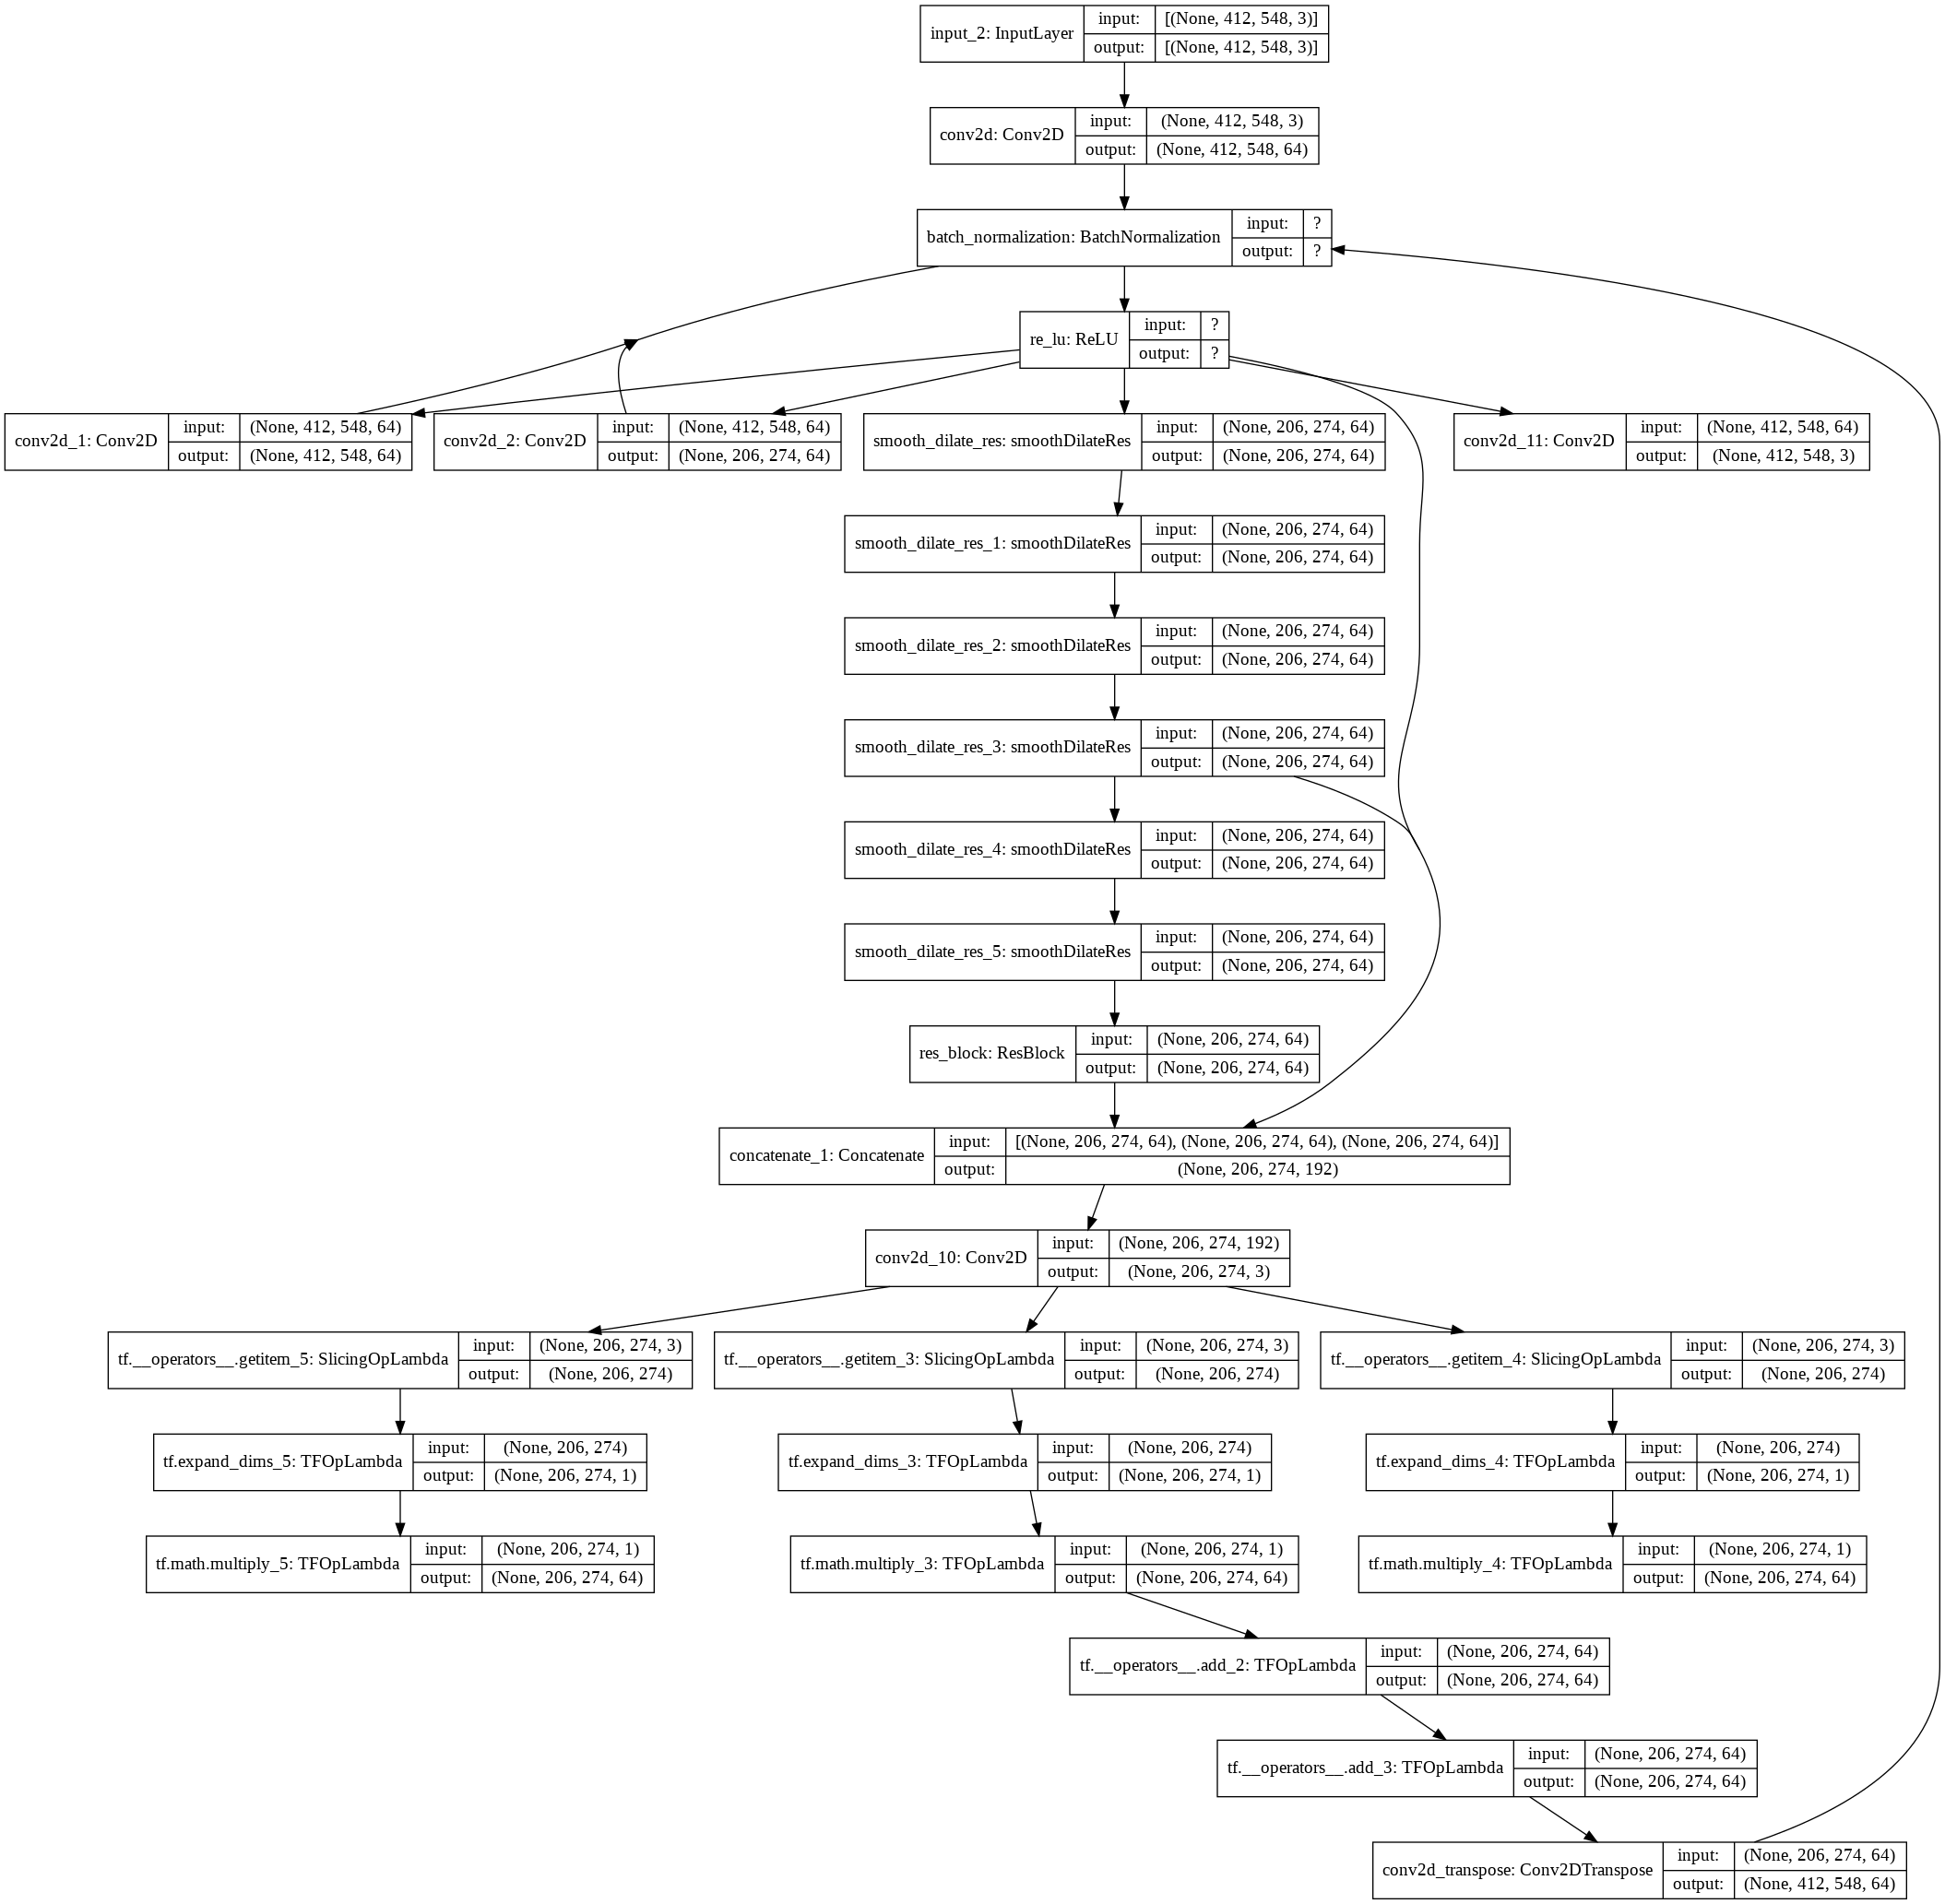

In [11]:
sub = GCA()
sub.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    sub.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)


In [22]:
# Hyperparameters
epochs = 10
batch_size = 4
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = './drive/MyDrive/dataset/clear_images', hazy_img_path = './drive/MyDrive/dataset/haze')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = GCA()
net.load_weights('/content/drive/MyDrive/nets/gca/weights')
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/gca',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

0


TypeError: ignored

In [13]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=====]  -  Training Loss: 0.0536

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


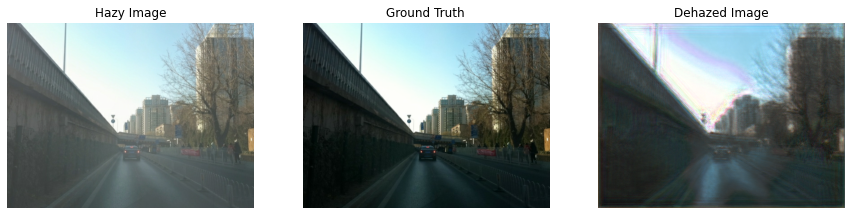

  -  Validation Loss: 0.2847  -   Time taken: 248.59s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [=====]  -  Training Loss: 0.0120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


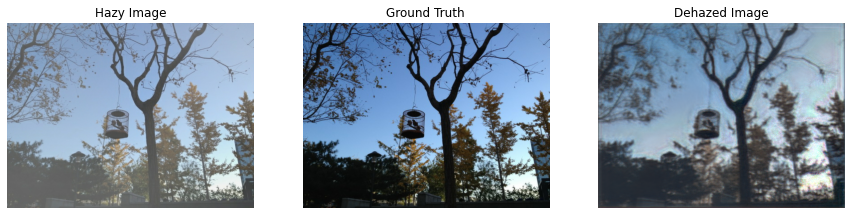

  -  Validation Loss: 0.2800  -   Time taken: 249.22s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [=====]  -  Training Loss: 0.0097

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


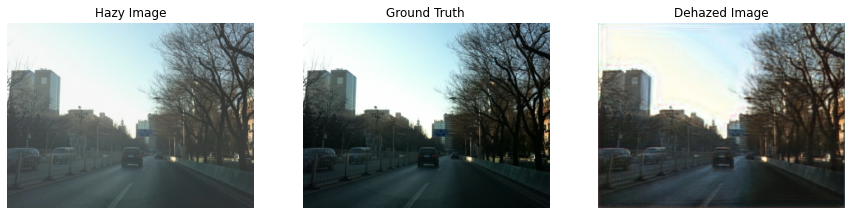

  -  Validation Loss: 0.2767  -   Time taken: 250.34s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [=====]  -  Training Loss: 0.0085

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


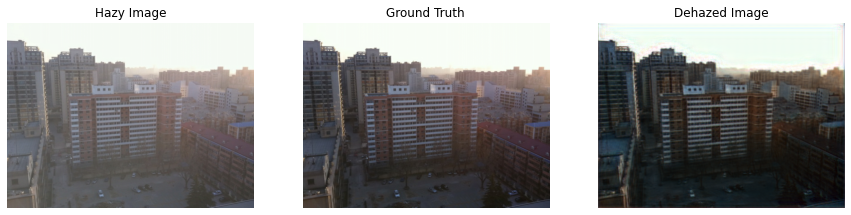

  -  Validation Loss: 0.2772  -   Time taken: 250.73s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 4 [=====]  -  Training Loss: 0.0080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


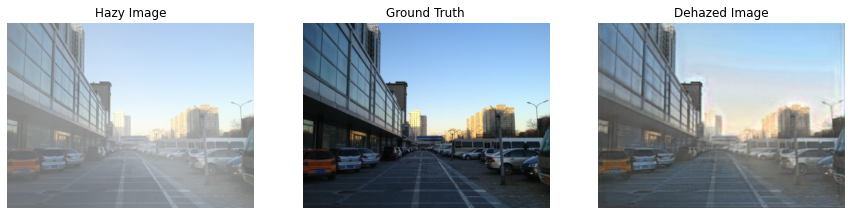

  -  Validation Loss: 0.2743  -   Time taken: 250.76s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 5 [=====]  -  Training Loss: 0.0075

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


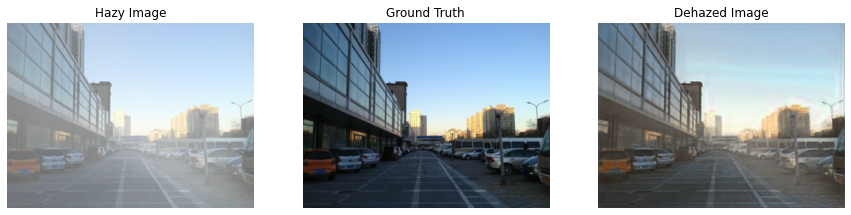

  -  Validation Loss: 0.2706  -   Time taken: 250.07s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 6 [=====]  -  Training Loss: 0.0073

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


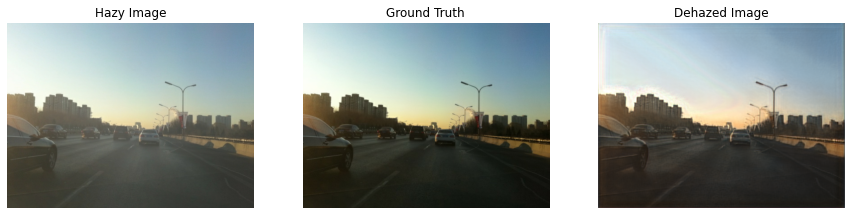

  -  Validation Loss: 0.2690  -   Time taken: 250.33s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 7 [=====]  -  Training Loss: 0.0072

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


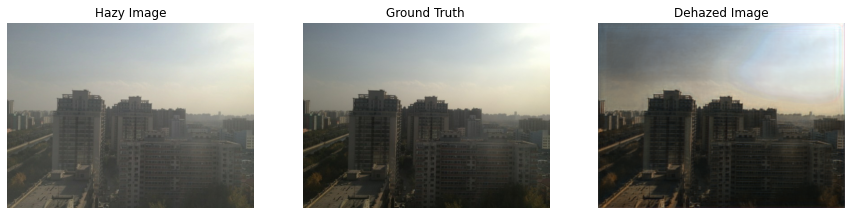

  -  Validation Loss: 0.2656  -   Time taken: 250.03s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 8 [=====]  -  Training Loss: 0.0068

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


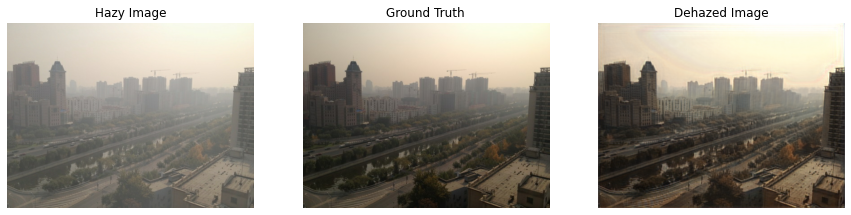

  -  Validation Loss: 0.2641  -   Time taken: 250.23s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 9 [=====]  -  Training Loss: 0.0068

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


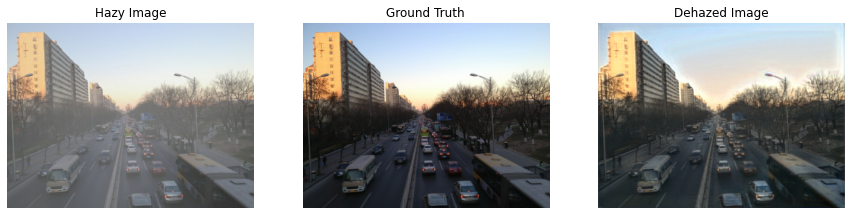

  -  Validation Loss: 0.2627  -   Time taken: 250.85s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 10 [=====]  -  Training Loss: 0.0064

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


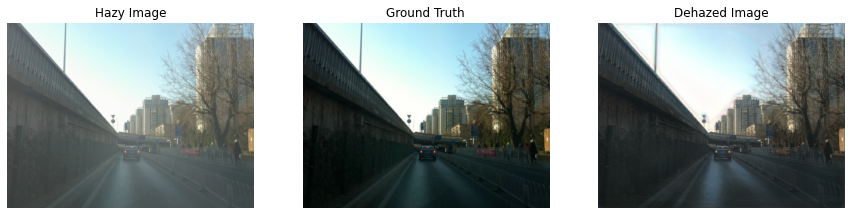

  -  Validation Loss: 0.2607  -   Time taken: 252.41s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 11 [=====]  -  Training Loss: 0.0063

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


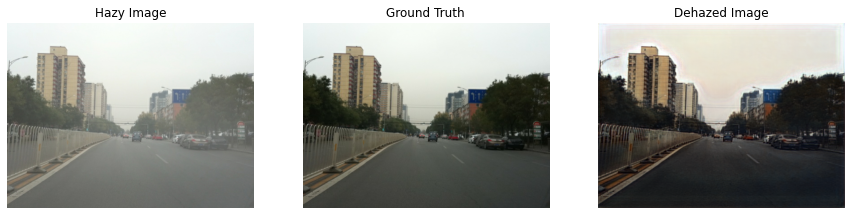

  -  Validation Loss: 0.2604  -   Time taken: 250.80s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 12 [====]  -  Training Loss: 0.0060

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


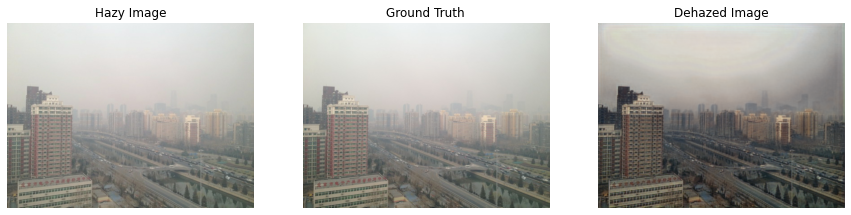

  -  Validation Loss: 0.2613  -   Time taken: 250.96s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 13 [=====]  -  Training Loss: 0.0061

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


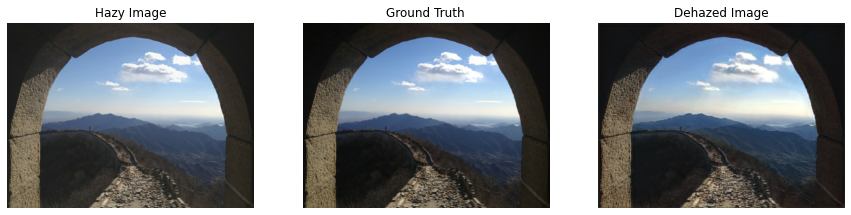

  -  Validation Loss: 0.2607  -   Time taken: 250.74s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 14 [=====]  -  Training Loss: 0.0060

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


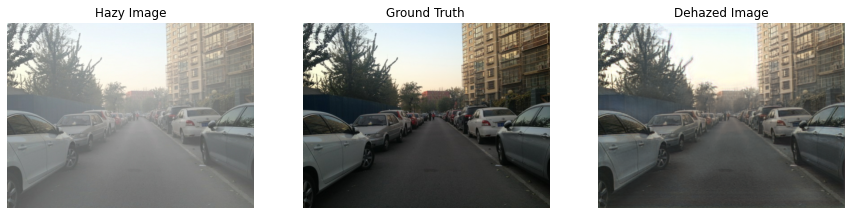

  -  Validation Loss: 0.2601  -   Time taken: 251.70s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 15 [=====]  -  Training Loss: 0.0059

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


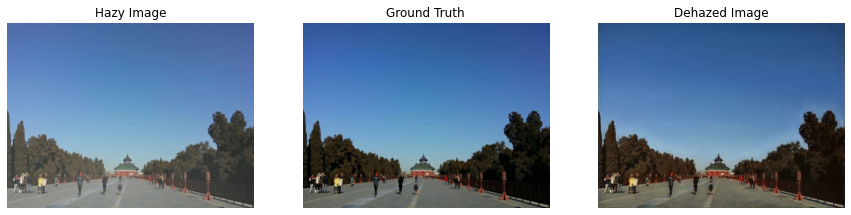

  -  Validation Loss: 0.2593  -   Time taken: 251.20s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 16 [=====]  -  Training Loss: 0.0055

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


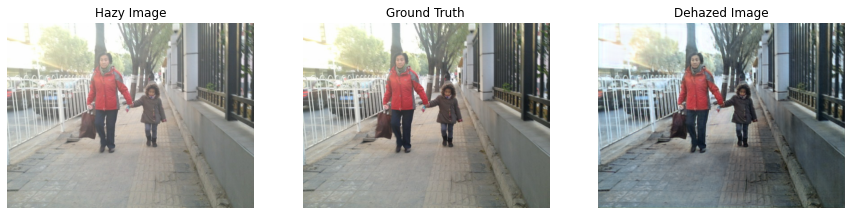

  -  Validation Loss: 0.2583  -   Time taken: 251.44s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 17 [=====]  -  Training Loss: 0.0056

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


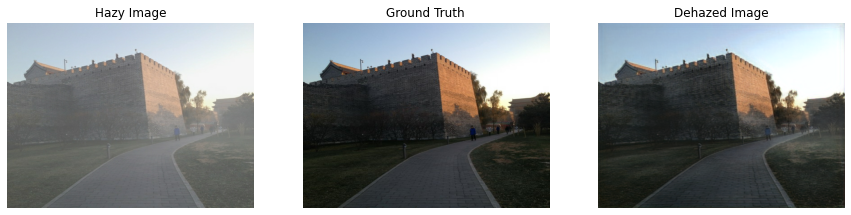

  -  Validation Loss: 0.2563  -   Time taken: 251.79s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 18 [=====]  -  Training Loss: 0.0054

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


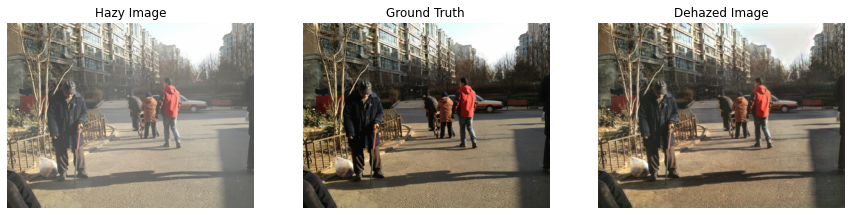

  -  Validation Loss: 0.2577  -   Time taken: 251.24s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 19 [=====]  -  Training Loss: 0.0054

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


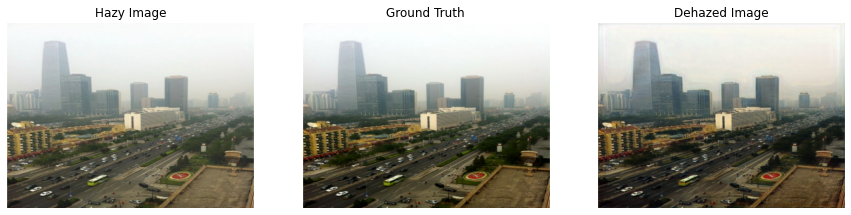

  -  Validation Loss: 0.2565  -   Time taken: 251.93s
INFO:tensorflow:Assets written to: trained_model/assets
CPU times: user 34min 12s, sys: 14min 12s, total: 48min 25s
Wall time: 1h 26min 5s


In [14]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [15]:
net.save('/content/drive/MyDrive/nets/gca')

net.save_weights('/content/drive/MyDrive/nets/gca/weights')
#model=net

#model.model().summary()


INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/gca/assets


In [19]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (412,548), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        dehaze=tf.image.resize(dehaze, size = (413,550), antialias = True)
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/gca'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, 

im)

        os.chdir('/content')
        i+=1;

In [20]:
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/gca/trained_model',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/test_custom_loss_net',compile=False)


#evaluate_gen(new_model)
evaluate_gen(net)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 

KeyboardInterrupt: ignored

In [ ]:
cp -r trained_model/ /content/drive/MyDrive/nets/gca/trained_model